In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit

In [3]:
df = pd.read_csv('../calibrationdata/RPRPData.csv')
data = df.to_numpy()

print(df.columns)

Index(['Frequency (Hz)', 'Vpp (V)', 'Displacement (Microns)',
       'Displacement (Microns) / Vampl (V)', 'A Uncertainty (V/microns)',
       'Phase (Radians)', 'Uncertainty (Radians)'],
      dtype='object')


In [4]:
freq = data[:, 0]
vpp = data[:, 1]
displ = data[:, 2]
a = data[:, 3]
a_sigma = data[:, 4]
phases = data[:, 5]
phases_sigma = data[:, 6]

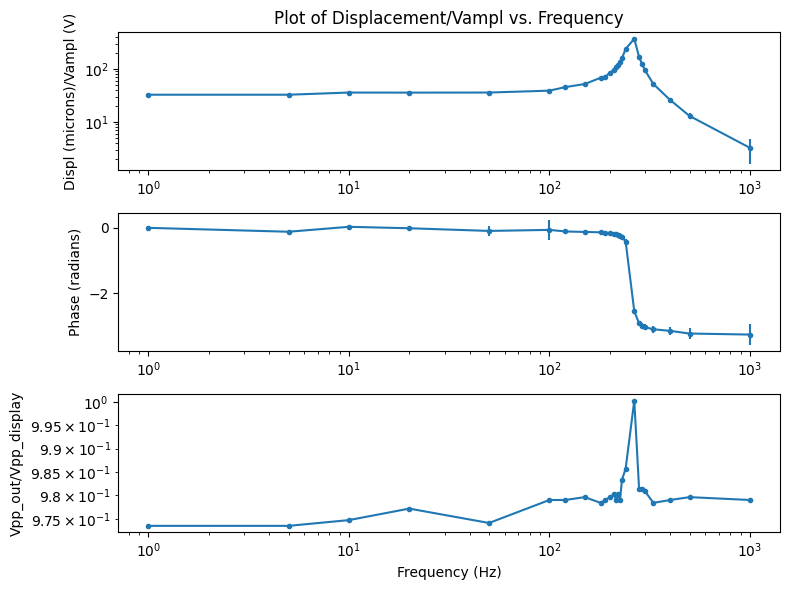

In [24]:
vampl = vpp/2

fig, ax = plt.subplots(3)
fig.set_size_inches(8, 6)

ax[0].errorbar(freq, a, yerr=a_sigma, marker='.')
ax[0].set_title("Plot of Displacement/Vampl vs. Frequency")
# ax[0].legend()
ax[0].loglog()
ax[0].set_ylabel("Displ (microns)/Vampl (V)")

ax[1].errorbar(freq, phases, marker='.', yerr=phases_sigma, label="0.2 Vpp Data")
ax[1].set_xscale('log')
ax[1].set_ylabel("Phase (radians)")

ax[2].plot(freq, vpp/0.2, marker='.')
ax[2].loglog()
ax[2].set_ylabel("Vpp_out/Vpp_display")
ax[2].set_xlabel("Frequency (Hz)")
plt.tight_layout()

Expected transfer function for displ/V_ampl assuming speaker is a damped harmonic oscillator:

$$
A = \frac{k f_0^2}{\sqrt{(f_0^2 - f^2)^2 + \frac{f_0^2}{Q^2}f^2}}
$$

In [25]:
def A(f, f0, Q, k):
    return (k * f0**2) / np.sqrt((f0**2 - f**2)**2 + f0**2*f**2/Q**2)

Add constant $c$ to add flexibility for potential phase offset from data between 20-1kHz: 


$$
\phi = \arctan \left( \frac{\frac{f_0}{Q} f}{f^2 - f_0^2} \right) + c
$$

In [26]:
def phase(f_trunc, f0, Q, c):
    return np.arctan2(f0/Q*f_trunc, f_trunc**2 - f0**2) + c

In [27]:
# for curve-fitting, start from 20Hz where Vpp_out/Vpp_display relatively 1:1
pfreq = freq
f_tot = np.append(pfreq, freq) 
y_tot = np.append(phases, a)

In [28]:
def combined_func(ftot, f0, Q, k, c):
    f_phase  = ftot[:len(pfreq)]
    f_ampl = ftot[len(pfreq):]
    
    phase_val = phase(f_phase, f0, Q, c)
    A_val = A(f_ampl, f0, Q, k)
    
    return np.append(phase_val, A_val)

In [29]:
model = lmfit.Model(combined_func, weights=np.append(1/phases_sigma[3:], 1/a_sigma[3:]), scale_covar=True)
params = model.make_params(f0=255, Q=30, k=1, c=-3)
params['Q'].set(min=0)
print(f'parameter names: {model.param_names}')
print(f'independent variables: {model.independent_vars}')

parameter names: ['f0', 'Q', 'k', 'c']
independent variables: ['ftot']


In [30]:
result = model.fit(y_tot, params, ftot=f_tot, weights=np.append(1/phases_sigma, 1/a_sigma), scale_covar=False)

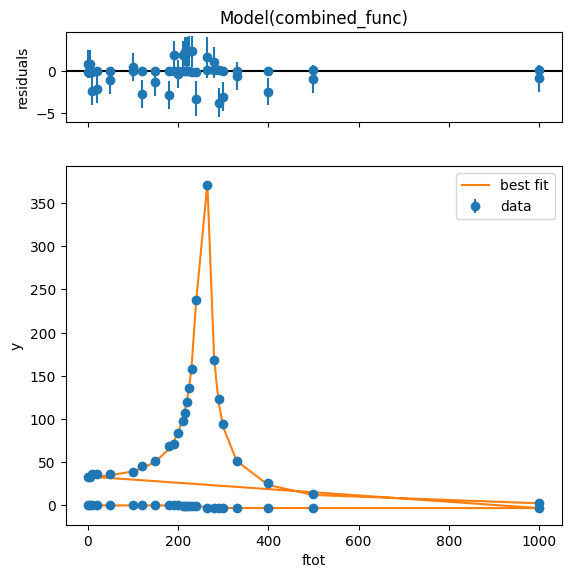

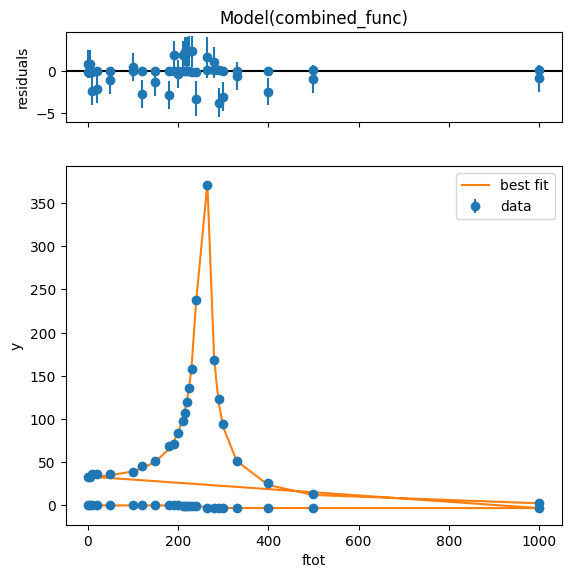

In [31]:
result.plot(yerr=np.append(phases_sigma, a_sigma))

In [32]:
result

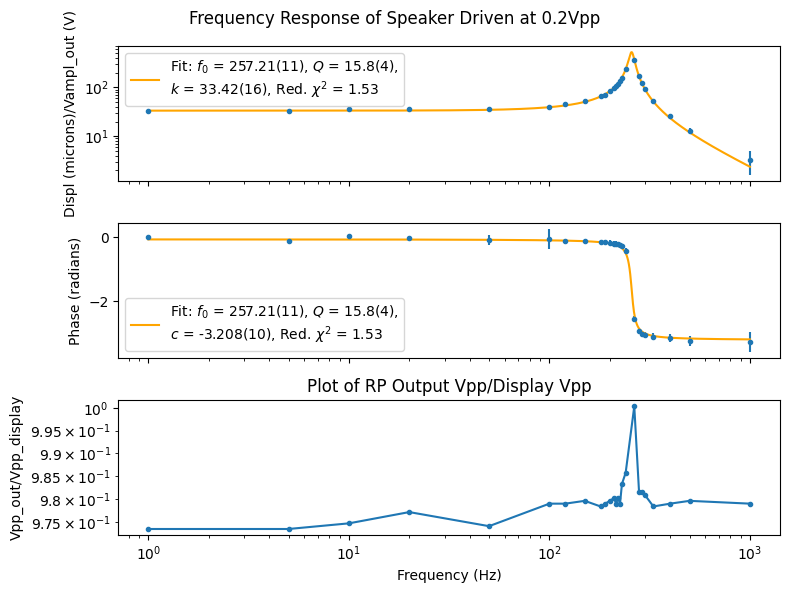

In [35]:
f0_uvar = result.uvars['f0']
Q_uvar = result.uvars['Q']
c_uvar = result.uvars['c']
k_uvar = result.uvars['k']
red_chi = result.redchi

fig, ax = plt.subplots(nrows=3, sharex='col')
fig.set_size_inches(8, 6)
ax[0].errorbar(freq, displ/vampl, marker='.', linestyle='', yerr=a_sigma)
freq_range = np.linspace(1, 1000, 1000)
ax[0].plot(
    freq_range,
    A(freq_range, result.params['f0'], result.params['Q'], result.params['k']),
    label=f'Fit: $f_0$ = {f0_uvar:SL}, $Q$ = {Q_uvar:SL},\n$k$ = {k_uvar:SL}, Red. $\chi^2$ = {red_chi:3.2f}',
    color="orange"
)
# ax[0].set_title("Plot of Displacement/Vampl vs. Frequency")
ax[0].legend()
ax[0].loglog()
ax[0].set_ylabel("Displ (microns)/Vampl_out (V)")
# ax[0].errorbar(freqs2, displ2/vampl2, yerr=displ2_sigma, fmt='none')
ax[1].errorbar(freq, phases, marker='.', linestyle="", yerr=phases_sigma)
pfreq_range = np.linspace(1, 1000, 1000)
ax[1].plot(
    pfreq_range,
    phase(pfreq_range, result.params['f0'], result.params['Q'], result.params['c']),
    label=f'Fit: $f_0$ = {f0_uvar:SL}, $Q$ = {Q_uvar:SL},\n$c$ = {c_uvar:SL}, Red. $\chi^2$ = {red_chi:3.2f}',
    color="orange")
ax[1].set_xscale('log')
# ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Phase (radians)")
ax[1].legend()

# ax[1].set_title("Plot of Phase vs. Frequency")
# ax[1].errorbar(freqs_phase, phases, yerr=phase_sigma, fmt='none')
ax[2].plot(freq, vpp/0.2, marker='.')
ax[2].loglog()
ax[2].set_ylabel("Vpp_out/Vpp_display")
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_title("Plot of RP Output Vpp/Display Vpp")

plt.suptitle("Frequency Response of Speaker Driven at 0.2Vpp")
plt.tight_layout()
# , $Q$ = {result.uvars['Q']:SL},\n$c$ = {result.uvars['c']:SL}, Red. $\chi^2$ = {result.redchi}

In [39]:
result.params['c']

<Parameter 'c', value=-3.208233068626455 +/- 0.00985, bounds=[-inf:inf]>